# About this notebook

This notebook explores methods of integrating fire occurrence predictions with economic data in order to estimate fire risk.
The economic data available to us are the value of structures, vehicles, and structure contents for San Diego county in the years 2011 and 2019. Here we explore predictions for the 2003 fire season using economic data from 2011 as a proxy for economic data in 2003, since the actual data from 2003 is not available to us.

## Loading the fire predictions

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('darkgrid')

In [2]:
%%time
import pandas as pd
import pyarrow.parquet as pq
import s3fs
import boto3

YEAR = 2003
prediction_url = 'wildfire_capstone/logistic_regression_predictions/{}/predictions.parquet.gz/'.format(YEAR)
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')
s3_keys = [item.key
           for item in s3_resource.Bucket('dse-cohort5-group5').objects.filter(Prefix=prediction_url)
           if item.key.endswith('.parquet')]
display(s3_keys[:3])
s3 = s3fs.S3FileSystem()
s3_url = 'dse-cohort5-group5/{}'
dfs = [pq.ParquetDataset(s3_url.format(key), filesystem=s3).read_pandas().to_pandas() for key in s3_keys]

['wildfire_capstone/logistic_regression_predictions/2003/predictions.parquet.gz/part-00000-f36beb34-41d2-4282-9fbd-d6b9b93d79eb-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2003/predictions.parquet.gz/part-00001-f36beb34-41d2-4282-9fbd-d6b9b93d79eb-c000.snappy.parquet',
 'wildfire_capstone/logistic_regression_predictions/2003/predictions.parquet.gz/part-00002-f36beb34-41d2-4282-9fbd-d6b9b93d79eb-c000.snappy.parquet']

Wall time: 49.9 s


In [3]:
num_rows = sum(len(df) for df in dfs)
num_rows

324850

In [4]:
dfs[0].head()

,date,latitude,longitude,fire_occurred,acres_burned,year,month,day,prediction
0,1067040000000000000,32.775000,-116.933333,1,270686.0,2003,10,25,1.0
1,1067040000000000000,32.941667,-116.766667,1,270686.0,2003,10,25,1.0


In [5]:
%%time
for df in dfs:
    df.date = pd.to_datetime(df.date)
    df.prediction = df.prediction.astype('int')
    df.set_index(['date', 'latitude', 'longitude'], inplace=True)
dfs[0].head()

Wall time: 1.1 s


fire_occurred  acres_burned  year month day  \
date       latitude  longitude                                                  
2003-10-25 32.775000 -116.933333              1      270686.0  2003    10  25   
           32.941667 -116.766667              1      270686.0  2003    10  25   

                                  prediction  
date       latitude  longitude                
2003-10-25 32.775000 -116.933333           1  
           32.941667 -116.766667           1

In [6]:
complete_df = pd.concat(dfs)
print(complete_df.shape)
complete_df.head()

(324850, 6)


fire_occurred   acres_burned  year month  \
date       latitude  longitude                                               
2003-10-25 32.775000 -116.933333              1  270686.000000  2003    10   
           32.941667 -116.766667              1  270686.000000  2003    10   
2003-10-26 32.566667 -116.766667              1   44734.128906  2003    10   
2003-10-25 32.900000 -116.933333              1  270686.000000  2003    10   
                     -116.891667              1  270686.000000  2003    10   

                                 day  prediction  
date       latitude  longitude                    
2003-10-25 32.775000 -116.933333  25           1  
           32.941667 -116.766667  25           1  
2003-10-26 32.566667 -116.766667  26           1  
2003-10-25 32.900000 -116.933333  25           1  
                     -116.891667  25           1

In [7]:
np.sum(complete_df.fire_occurred)

174

In [8]:
np.sum(complete_df.prediction)

96350

In [9]:
yearly_totals_df = complete_df.groupby(by=['latitude', 'longitude']).agg(
    total_actual_fires=pd.NamedAgg(column='fire_occurred', aggfunc='sum'),
    total_predicted_fires=pd.NamedAgg(column='prediction', aggfunc='sum'),
)
yearly_totals_df.head()

total_actual_fires  total_predicted_fires
latitude  longitude                                             
32.483333 -117.141667                   0                    162
          -117.100000                   0                    241
          -117.058333                   0                    253
          -117.016667                   0                    249
          -116.975000                   0                    240

In [10]:
yearly_totals_df.total_actual_fires.value_counts()

0    723
1    161
2      5
3      1
Name: total_actual_fires, dtype: int64

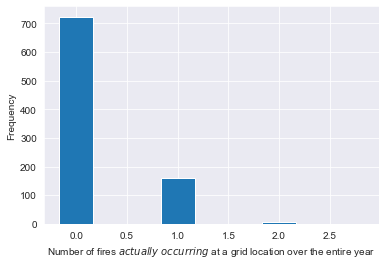

In [11]:
ax = yearly_totals_df.total_actual_fires.hist(bins=9, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{actually\ occurring}$ at a grid location over the entire year");

In [12]:
yearly_totals_df.total_predicted_fires.value_counts()

0      65
143    17
1      15
142    14
152    14
       ..
40      1
198     1
35      1
199     1
253     1
Name: total_predicted_fires, Length: 208, dtype: int64

In [13]:
np.max(yearly_totals_df.total_predicted_fires.value_counts().index)

253

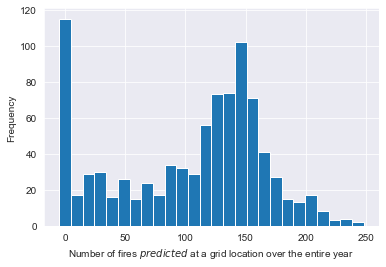

In [14]:
ax = yearly_totals_df.total_predicted_fires.hist(bins=268//10, align='left')
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of fires $\mathit{predicted}$ at a grid location over the entire year");

In [15]:
yearly_totals_df['%_days_predicted_fires'] =yearly_totals_df.total_predicted_fires / 365

Pearson correlation coefficient: 0.32513915451625686


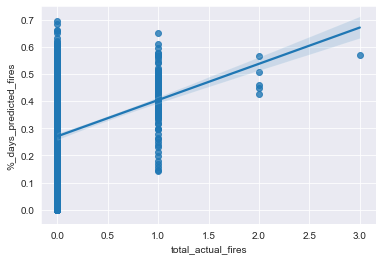

In [25]:
pearson = yearly_totals_df.loc[:, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
print("Pearson correlation coefficient:", pearson)
sns.regplot(data=yearly_totals_df, x='total_actual_fires', y='%_days_predicted_fires');

## Some observations

Unfortunately there is no real correlation between the number of predicted fires and the number of actual fires overall.
Can we get better results by restricting our attention to some particular grid locations? For example, do we get good predictions at the most valuable grid locations?

# Economic data

Let's explore the economic data a bit to determine the most valuable grid locations.

In [17]:
econ_df = pd.read_csv('grid_econ_1.csv', index_col=0)
print(econ_df.shape)
econ_df.head()

(507, 10)


,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN


In [18]:
econ_df['total_value'] = np.sum(econ_df[['Val_Struct', 'Val_Cont', 'Val_Other', 'Val_Vehic']], axis=1)
econ_df.head()

,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential,total_value
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0,2.430361e+08
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0,4.430585e+07
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0,3.829353e+08
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0,1.035808e+08
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN,4.599620e+06


(152, 11)
Pearson correlation coefficient: 0.3128922008505193


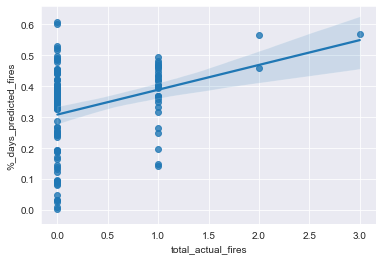

In [26]:
mask = (econ_df.total_value > econ_df.total_value.quantile(0.7))
most_valuable_locations = econ_df[mask]
print(most_valuable_locations.shape)
most_valuable_lons = most_valuable_locations.longitude
most_valuable_lats = most_valuable_locations.latitude
mask = (yearly_totals_df.reset_index().latitude.isin(most_valuable_lats) &
       yearly_totals_df.reset_index().longitude.isin(most_valuable_lons))
pearson = yearly_totals_df.reset_index().loc[mask, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
print("Pearson correlation coefficient:", pearson)
sns.regplot(data=yearly_totals_df.reset_index()[mask], x='total_actual_fires', y='%_days_predicted_fires');

## Conclusions

In this analysis the correlation is not significantly changed for the most valuable regions. However given the larger amount of time between the fire season and the available economic data, the analysis may be suffering from a data quality issue.